In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

In [2]:
sequence_length = 4
batch_size = 1
input_dim = 512
d_model = 512
x = torch.randn( (batch_size, sequence_length, input_dim) )

In [3]:
x.size()

torch.Size([1, 4, 512])

In [4]:
qkv_layer = nn.Linear(input_dim, 3 * d_model)

In [5]:
qkv = qkv_layer(x)

In [6]:
qkv.shape

torch.Size([1, 4, 1536])

Text(0.5, 1.0, 'qkv_distribution')

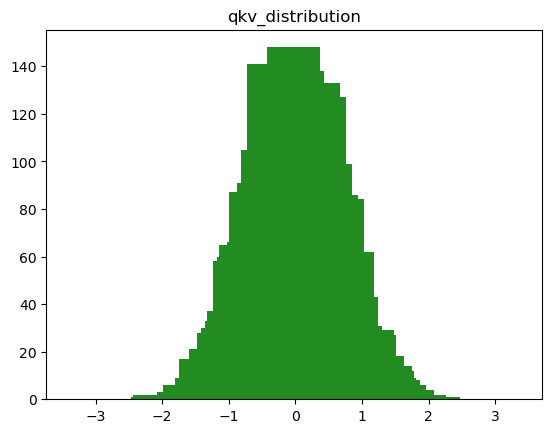

In [7]:
import matplotlib.pyplot as plt
y_val = torch.histc(qkv, bins=200, min=-3, max=3)
x_val = torch.arange(-1, 1, 0.01)*3
plt.bar(x_val, y_val, align='center', color=['forestgreen'])
plt.title('qkv_distribution')

In [8]:
num_heads = 8
head_dim = d_model // num_heads
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3 * head_dim)

In [9]:
qkv.shape

torch.Size([1, 4, 8, 192])

In [10]:
qkv = qkv.permute(0, 2, 1, 3) #[batch_size, num_heads, sequence_length, 3 * head_dim]
qkv.shape

torch.Size([1, 8, 4, 192])

In [11]:
q, k, v = qkv.chunk(3, dim = -1)
q.shape, k.shape, v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

In [12]:
d_k = q.size()[-1]
scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
scaled.shape

torch.Size([1, 8, 4, 4])

In [13]:
k.T.shape

/var/folders/sx/dt5qpwfn4q126g_lvt2bj3ph0000gn/T/ipykernel_3600/3717780648.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3641.)
  k.T.shape


torch.Size([64, 4, 8, 1])

In [14]:
y = torch.randn(2, 3)
torch.transpose(y, 0, 1)

tensor([[ 0.8973, -1.1792],
        [-1.5083, -0.7276],
        [-1.2124, -3.1014]])

In [15]:
torch.transpose(y, 1, 0)

tensor([[ 0.8973, -1.1792],
        [-1.5083, -0.7276],
        [-1.2124, -3.1014]])

In [16]:
mask = torch.full(scaled.size(), float('-inf'))
mask = torch.triu(mask, diagonal=1)
mask[0][1] # mask for input to a single head

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [17]:
(scaled + mask)[0][0]

tensor([[-0.2695,    -inf,    -inf,    -inf],
        [ 0.0853, -0.1437,    -inf,    -inf],
        [-0.2554, -0.0819, -0.2362,    -inf],
        [-0.1597,  0.0207,  0.1325, -0.3650]], grad_fn=<SelectBackward0>)

In [18]:
scaled += mask

In [19]:
np.exp(.5886)/(np.exp(.5886) + np.exp(.2052))

0.594692879155492

In [20]:
attention = F.softmax(scaled, dim=-1)

In [21]:
attention.shape

torch.Size([1, 8, 4, 4])

In [22]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.5570, 0.4430, 0.0000, 0.0000],
        [0.3116, 0.3707, 0.3177, 0.0000],
        [0.2298, 0.2752, 0.3078, 0.1872]], grad_fn=<SelectBackward0>)

In [23]:
values = torch.matmul(attention, v)
values.shape

torch.Size([1, 8, 4, 64])

In [24]:
#In a single function
def scaled_dot_product(q, k, v, mask = None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

In [25]:
values, attention = scaled_dot_product(q, k, v, mask=mask)

In [26]:
attention.shape

torch.Size([1, 8, 4, 4])

In [27]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.5570, 0.4430, 0.0000, 0.0000],
        [0.3116, 0.3707, 0.3177, 0.0000],
        [0.2298, 0.2752, 0.3078, 0.1872]], grad_fn=<SelectBackward0>)

In [28]:
values = values.reshape(batch_size, sequence_length, num_heads * head_dim)
values.size()

torch.Size([1, 4, 512])

In [36]:
out = linear_layer(values)

In [37]:
out.shape

torch.Size([1, 4, 512])